In [5]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
import seaborn as sns
import chardet
import pandas as pd
import numpy as np

def get_data():
    #  读取二进制文件内容
    file_name = './data/tick_data.csv'
    with open(file_name, 'rb') as f:
        result = chardet.detect(f.read())

    # 获取检测到的编码格式
    encoding = result['encoding']

    # 使用检测到的编码格式读取文件
    tick_data = pd.read_csv(
        file_name,
        encoding=encoding,
    )
    tick_data.drop(columns=['市场代码', '证券代码'], inplace=True)

    return tick_data

def train1(iterations=500, learning_rate=0.05, depth=10):
    tick_data = get_data()
    tick_data['时间'] = pd.to_datetime(tick_data['时间'])
    tick_data['时间'] = (tick_data['时间'] - tick_data['时间'].min()) / np.timedelta64(1, 's')
    tick_data = tick_data.sort_values(by='时间')

    # 创建涨跌标签
    tick_data['涨跌'] = np.where(tick_data['最新价'].diff() > 0, 1, 0)

    train_size = int(len(tick_data) * 0.7)
    val_size = int(len(tick_data) * 0.1)
    train_data, test_data = tick_data[:train_size], tick_data[train_size:]

    def create_dataset(data, time_step=1):
        data = data.values
        X, Y = [], []
        for i in range(len(data) - time_step):
            a = data[i:(i + time_step), :-1]
            X.append(a.flatten())
            Y.append(data[i + time_step, -1])
        return np.array(X), np.array(Y)

    time_step = 10
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # 创建CatBoost分类模型
    model = CatBoostClassifier(iterations=iterations,
                            learning_rate=learning_rate,
                            depth=depth,
                            loss_function='Logloss',
                            verbose=False)

    train_pool = Pool(X_train, y_train)
    model.fit(train_pool)

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # 绘制混淆矩阵
    cm = confusion_matrix(y_test, test_predict)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return model

train1(**{'depth': 6, 'iterations': 100, 'learning_rate': 0.05})


UnboundLocalError: local variable 'tick_data' referenced before assignment

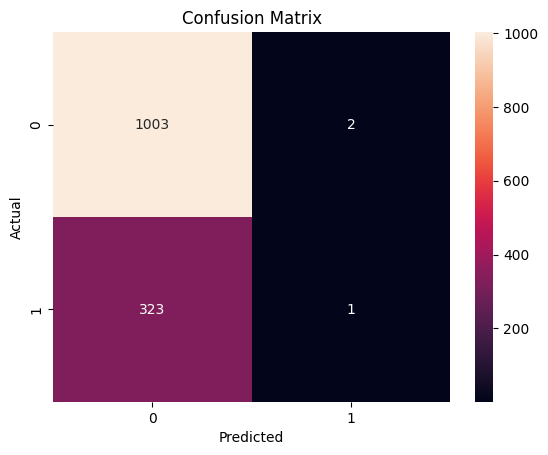

In [34]:
train1()